# Example: Stable and manipulable Bloch point

This notebook serves as an example of using Ubermag (with OOMMF as a computational backend) for reproducing a figure in a publication. More precisely, in this notebook, we are going to reproduce Figure 3 from published in

[Beg *et al.* Stable and manipulable Bloch point. *Scientific Reports*, **9**, 7959 (2019)](https://doi.org/10.1038/s41598-019-44462-2).

We need to simulate hysteretic behaviour of a $150 \,\text{nm}$ disk, which consists of two layers with different sign of Dzyaloshinkii-Moriya constant $D$. The bottom layer with $D<0$ has $20 \,\text{nm}$ thickness, whereas the top layer with $D>0$ has $10 \,\text{nm}$ thickness. We start by importing the necessary modules and creating the mesh with two regions.

In [1]:
import oommfc as oc
import discretisedfield as df
%matplotlib inline

d = 150e-9
hb = 20e-9
ht = 10e-9
cell = (5e-9, 5e-9, 2.5e-9)
regions = {'r1': df.Region(p1=(-d/2, -d/2, -hb), p2=(d/2, d/2, 0)),
           'r2': df.Region(p1=(-d/2, -d/2, 0), p2=(d/2, d/2, ht))}
p1 = (-d/2, -d/2, -hb)
p2 = (d/2, d/2, ht)
mesh = oc.Mesh(p1=p1, p2=p2, cell=cell, regions=regions)

The mesh domain and the discretisation cells are:

In [2]:
mesh.k3d()

Output()

and the two regions we defined are:

In [3]:
mesh.k3d_regions()

Output()

Now, we need to define the system object, and by setting magnetisation saturation, set the geometry to be a disk.

In [4]:
D = {'r1': 1.58e-3, 'r2': -1.58e-3, 'r1:r2': 1.58e-9}
Ms = 3.84e5
A = 8.78e-12

def Ms_fun(pos):
    x, y, z = pos
    if x**2 + y**2 <= (d/2)**2:
        return Ms
    else:
        return 0

system = oc.System(name='bloch-point')
system.hamiltonian = oc.Exchange(A=A) + oc.DMI(D=D, crystalclass='T') + oc.Demag()
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms_fun)

Our sample is now:

In [5]:
system.m.norm.k3d_nonzero()

Output()

The magnetisation in the horizontal cross-section is:

In [6]:
system.m.plane('z').k3d_vectors(head_size=30)

Output()

Now, we can minimise the system's energy by using `MinDriver`.

In [7]:
md = oc.MinDriver()
md.drive(system, overwrite=True)

2019/11/13 13:35: Running OOMMF (bloch-point.mif) ... (1.6 s)


The out-of-plane magnetisation component ($m_{z}$) is now:

In [8]:
system.m.z.k3d_voxels(norm_field=system.m.norm)

Output()

We can see that two vortices with different orientation emerged. We can inspect this closer by plotting two layers of magnetisation in two different layers:

In [9]:
import k3d
plot = k3d.plot()
system.m.plane(z=-10e-9, n=(20, 20)).k3d_vectors(plot=plot, color_field=system.m.z, head_size=30)
system.m.plane(z=5e-9, n=(20, 20)).k3d_vectors(plot=plot,color_field=system.m.z, head_size=30)
plot.display()

Output()

We can now plot another cross section and see that the Bloch point emerged.

In [10]:
system.m.plane('y').k3d_vectors(color_field=system.m.z, head_size=20)

Output()

In [11]:
system.m.z.plane('y').k3d_voxels(color_field=system.m.z)

Output()

Finally, we can simulate the hysteresis loop.

In [12]:
import numpy as np

# Create an array of external fields for which the system is relaxed.
Bmax = 1  # maximum field in hysteresis (T)
dB = 0.1  # field step (T)
B_array = np.concatenate([np.arange(Bmax, -Bmax, -dB),
                          np.arange(-Bmax, Bmax+1e-12, dB)])

system.hamiltonian += oc.Zeeman(H=(0, 0, 0))
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms_fun)
mz = []
for B in B_array:
    system.hamiltonian.zeeman.H = (0, 0, B/oc.consts.mu0)
    md.drive(system, overwrite=True)
    mz.append(system.m.average[2])

2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.3 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.2 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.2 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.3 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.3 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.4 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.4 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.3 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.3 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.2 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.2 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.3 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.3 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.4 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.7 s)
2019/11/13 13:36: Running OOMMF (bloch-point.mif) ... (1.8 s)
2019/11/

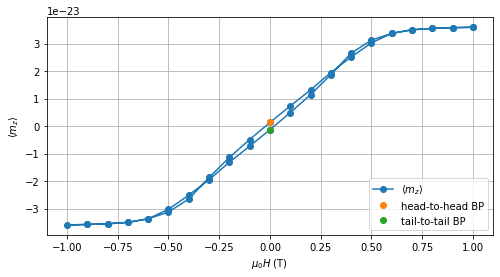

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

mz = np.array(mz)/Ms

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(B_array, mz, 'o-', label=r"$\langle m_{z} \rangle$")
ax.plot(0, mz[10], 'o', label='head-to-head BP')
ax.plot(0, mz[30], 'o', label='tail-to-tail BP')
plt.xlabel(r"$\mu_{0}H$ (T)")
plt.ylabel(r"$\langle m_{z} \rangle$")
plt.legend(loc=4)
plt.grid()

In [19]:
system.delete()

## Other

More details on various functionality can be found in the [API Reference](https://oommfc.readthedocs.io/en/latest/).